In [11]:
import cv2 as cv
import numpy as np 
import matplotlib.pyplot as plt
import math as mth

def BresenhamLine(x1,y1,x2,y2):
    #zmienne pomocnicze
    d=0
    dx=0
    dy=0
    ai=0
    bi=0
    xi=0
    yi=0
    x=x1
    y=y1
    
    vertexes_x=[]
    vertexes_y=[]
    
    # ustalenie kierunku rysowania
    if(x1 < x2):
        xi = 1
        dx = x2 - x1
    else:
        xi = -1
        dx = x1 - x2
     
    # ustalenie kierunku rysowania
    if (y1 < y2):
        yi = 1
        dy = y2 - y1
    else:
        yi = -1
        dy = y1 - y2

     # pierwszy piksel
    vertexes_x.append(x)
    vertexes_y.append(y)
    
     # oś wiodąca OX
    if (dx > dy):
        ai = (dy - dx) * 2
        bi = dy * 2
        d = bi - dx
        #pętla po kolejnych x
        while (x != x2):
            #test współczynnika
            if (d >= 0):
                x += xi
                y += yi
                d += ai
            else:
                d += bi
                x += xi
                
            vertexes_x.append(x)
            vertexes_y.append(y)
     #oś wiodąca OY
    else:
        ai = ( dx - dy ) * 2
        bi = dx * 2
        d = bi - dy
        #pętla po kolejnych y
        while (y != y2):
             #test współczynnika
            if (d >= 0):
                x += xi
                y += yi
                d += ai
            else:
                d += bi
                y += yi
             
            vertexes_x.append(x)
            vertexes_y.append(y)
    return vertexes_x,vertexes_y


<class 'numpy.ndarray'>


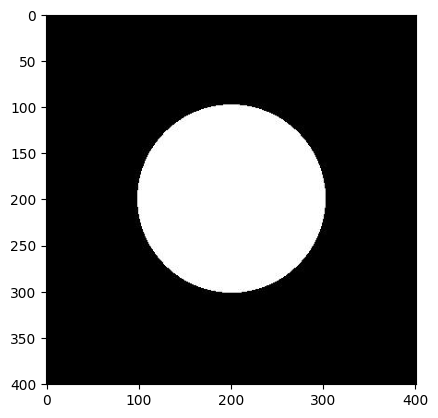

In [32]:
def addPadding(img):
    result = np.zeros([max(img.shape), max(img.shape)]) if max(img.shape) % 2 == 1 else np.zeros(
        [max(img.shape) + 1, max(img.shape) + 1])
    result[:img.shape[0], :img.shape[1]] = img
    return result

img = cv.imread('C:\\main\\Medycyna\\tomograf\\zdjecia\\Kolo.jpg', cv.IMREAD_GRAYSCALE)
print (type(img))
img = addPadding(img)
plt.imshow(img, cmap='gray')

In [35]:

def radon(img, delta_alpha, num, l):
    size = min(img.shape)
    x, y, x1, y1 = [], [],[], []
    sinogram = []
    radius = size // 2

    theta = np.arange(0, 360, delta_alpha)
    offsets=np.linspace(-l/2,l/2,num)

    for i in theta:

        xe = radius * np.cos(np.deg2rad(i)) + radius
        ye = radius * np.sin(np.deg2rad(i)) + radius
        x.append(xe)
        y.append(ye)

        lines_coords=[]

        for n in range(num):
            
            xD = radius * np.cos(np.deg2rad(i + offsets[n] + 180) ) + radius
            yD = radius * np.sin(np.deg2rad(i+ offsets[n] + 180) ) + radius
            #xD = radius * np.cos(np.deg2rad(i + np.pi - l/2 + n * l/(num-1) ) ) + radius
            #yD = radius * np.sin(np.deg2rad(i + np.pi - l/2 + n * l/(num-1) ) ) + radius
            x1.append(xD)
            y1.append(yD)
        

            lines_coords.append(BresenhamLine(int(xe), int(ye), int(xD), int(yD)))
            #bres, sex = list(BresenhamLine(int(xe), int(ye), int(xD), int(yD)))
            #plt.plot(bres, sex)

        lines_brightnesses=[]

        for line in lines_coords:
            res=0
            for i in range(len(line[0])):
                if(line[0][i]<size and line[1][i]<size): 
                    res+=img[line[0][i],line[1][i]]
            lines_brightnesses.append(res/len(line[0])) #normalization
    
        #filter
        plt.show()   
        sinogram.append(lines_brightnesses)
    return sinogram


    


    #plt.scatter(x, y)
    #plt.scatter(x1, y1)
    #plt.xlabel("X")
    #plt.ylabel("Y")
    #plt.show()


sinogram = radon(img, 2, 180, 180)
print(type(sinogram))
plt.imshow(sinogram,cmap='gray')

<class 'list'>


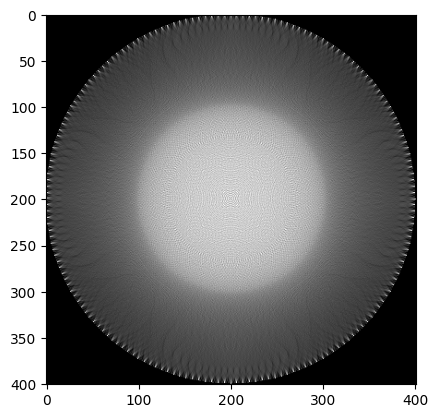

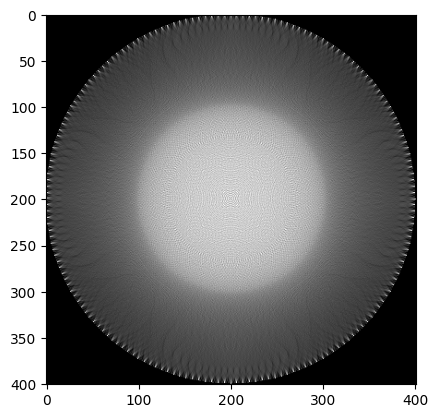

In [31]:
def i_radon(img, delta_alpha, num, l):
    size = min(img.shape)
    partial_output=[]
    radius = size // 2

    theta = np.arange(0, 360, delta_alpha)
    offsets=np.linspace(-l/2,l/2,num)

    for i in theta:

        xe = radius * np.cos(np.deg2rad(i)) + radius
        ye = radius * np.sin(np.deg2rad(i)) + radius
        lines_coords=[]

        for n in range(num):
            
            xD = radius * np.cos(np.deg2rad(i + offsets[n] + 180) ) + radius
            yD = radius * np.sin(np.deg2rad(i+ offsets[n] + 180) ) + radius
        
            lines_coords.append(BresenhamLine(int(xe), int(ye), int(xD), int(yD)))

        lines_brightnesses=[]

        for line in lines_coords:
            res=0
            for i in range(len(line[0])):
                if(line[0][i]<size and line[1][i]<size): 
                    res+=img[line[0][i],line[1][i]]
            lines_brightnesses.append(res/len(line[0])) #normalization

        output=np.zeros((size, size))



        for i in range(len(lines_coords)):
            for j in range(len(lines_coords[i][0])):
                x=lines_coords[i][0][j]
                y=lines_coords[i][1][j]

                if(x<size and y<size): 
                    output[x][y]+=lines_brightnesses[i]
        #normalization
        output/=len(lines_coords)
    
        #result of this iteration
        partial_output.append(output)
    plt.imshow(sum(partial_output),cmap='gray')
    plt.show()
    
    partial_avg_output=[np.zeros((size, size)) for i in range(len(theta))]
    
    for i in range(size):
        for j in range(size):
            suma=0
            for iteration in range(0,len(theta)):
                suma+=partial_output[iteration][i][j]
                partial_avg_output[iteration][i][j]=suma/(iteration+1)     
    
    #normalize final image and result of each iteration
    for i in range(len(partial_avg_output)):
        cv.normalize(partial_avg_output[i], partial_avg_output[i], alpha=0, beta=1, norm_type=cv.NORM_MINMAX)   
    
    return partial_avg_output

result = i_radon(img, 2, 180, 180)
plt.imshow(result[179],cmap='gray')